## Planck 857 GHz vs. CMASS

In [ ]:
%matplotlib inline
import fitsio
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from corr_utility import *

#####################################
##            Constants            ##
#####################################
fgal =  '/Users/jh/Desktop/data/SDSS/data/galaxy_DR12v5_CMASS_North.fits'
fmap ={ 857:'/Users/jh/Desktop/data/Planck/HFI_SkyMap_857_2048_R2.02_full.fits'}
pcField = {353:3, 545:4, 857:5}
fmapMaskPlane = '/Users/jh/Desktop/data/Planck/HFI_Mask_GalPlane-apo2_2048_R2.00.fits'
fmapMaskPS = '/Users/jh/Desktop/data/Planck/HFI_Mask_PointSrc_2048_R2.00.fits'
NSIDE = 512
NSIDE_Planck = 2048
LMAX = 1024
mapFreq = 857
planeMaskField = 1 ##field: 20% 40% 60% 70% 80%

rot = [0, np.pi]
fn_clout = 'test.out'

#####################################
##           Galaxies              ##
#####################################
theta = np.array([])
phi   = np.array([])

fits = fitsio.FITS(fgal)
theta = fits[1]['DEC'][:]
phi   = fits[1]['RA'][:]
fits.close()

##===  (ra, dec) -> (theta, phi)
theta = (-1)*theta*np.pi/180. + np.pi/2.
phi = phi*np.pi/180. 

##===  Celestial coordinate -> galactic coordinate
r_C2G = hp.Rotator(coord=['C', 'G'], rot=rot)
theta, phi = r_C2G(theta, phi)

#==============  galaxies --> pixel =================
galMap = np.zeros(hp.nside2npix(NSIDE))
galPix = hp.ang2pix(NSIDE, theta, phi)

for pix in galPix:
    galMap[pix] += 1  ## count map

hp.mollview(galMap, title="LRGs count map")
plt.show()    

##============= mask out south  ====================
maskHemi =  np.arange(hp.nside2npix(NSIDE))
npixs = len(maskHemi)
for i in xrange(npixs):
    if (i<= npixs/2):
        maskHemi[i] = True
    else:
        maskHemi[i] = False

galMapMasked = hp.ma(galMap)
galMapMasked.mask = np.logical_not(maskHemi)        
        

##============ count --> overdensity ==================
galMap_Ngal = 0
galMap_Npix = 0  ## keep track of the number of pixels covered
for i in xrange(len(galMapMasked)):
    if galMapMasked[i] == 0:
        galMapMasked[i] = hp.UNSEEN
    if galMapMasked[i] != hp.UNSEEN:
        galMap_Ngal+=galMapMasked[i]
        galMap_Npix+=1
        

countMean = float(galMap_Ngal)/galMap_Npix

for i in xrange(len(galMapMasked)):
    if galMapMasked[i] != hp.UNSEEN:
        galMapMasked[i] = (galMapMasked[i] - countMean)/countMean


hp.mollview(galMapMasked, title='LRGs overdensity map')
plt.show()
##=========================================================


######################################
##           Planck Map             ##
######################################

planckmap = hp.read_map(fmap[mapFreq])*10**6
hp.mollview(planckmap, title="Plank %i GHz"%(mapFreq))
plt.show()

##====== mask out south, plane and PS ========
maskPS = hp.read_map(fmapMaskPS, field=pcField[mapFreq]).astype(bool) ##field=5 for F857
maskPlane = hp.read_map(fmapMaskPlane, field=planeMaskField).astype(bool) 

maskHemi =  np.arange(hp.nside2npix(NSIDE_Planck))
npixs = len(maskHemi)
for i in xrange(npixs):
    if (i<= npixs/2):
        maskHemi[i] = True
    else:
        maskHemi[i] = False

mask = np.logical_and(maskPS, maskPlane)
mask = np.logical_and(mask, maskHemi)
planckmapMasked = hp.ma(planckmap)
planckmapMasked.mask = np.logical_not(mask)

hp.mollview(planckmapMasked,title="Plank %i GHz masked"%(mapFreq))
plt.show()
##======== substract mean; normalize ======
# map_I = 0.0
# Npixs = 0
# for i in xrange(len(planckmapMasked)):
#     if planckmapMasked[i] != hp.UNSEEN:
#         map_I += planckmapMasked[i]
#         Npixs += 1
# Ibar = map_I/Npixs
# for i in xrange(len(planckmapMasked)):
#     if planckmapMasked[i] != hp.UNSEEN:
#         planckmapMasked[i] = (planckmapMasked[i] - Ibar)/Ibar

# hp.mollview(planckmapMasked,title="Plank %i GHz masked, normalized"%(mapFreq))
# plt.show()
#######################################
##    Spherical Harmonics            ##
#######################################

## CIB auto-power spectrum
cl = hp.anafast(planckmapMasked, lmax=LMAX)
ell = np.arange(len(cl))
plt.plot(ell, ell*(ell+1)*cl)
plt.xlabel('$l$')
plt.ylabel('$l(l+1) C_l$')
plt.title('Plank %i Ghz auto-power spectrum'%(mapFreq))
plt.show()

## galaxy auto-power spectrum
clGal = hp.anafast(galMapMasked, lmax=LMAX, pol=False)
ellGal = np.arange(len(clGal))
plt.plot(ellGal, clGal)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$l$')
plt.ylabel('$C_l$')
#plt.ylim([10**-7, 10**-3])
plt.title('auto-power spectrum')
plt.show()

## cross-power spectrum
clCross = hp.anafast(galMapMasked, planckmapMasked, lmax = LMAX)
ellCross = np.arange(len(clCross))
plt.plot(ellCross, ellCross*(ellCross+1)*clCross)
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('$l$')
plt.ylabel('$l(l+1)C_l$')
plt.title('galaxy and Planck %i GHz cross-power spectrum'%(mapFreq))
plt.show()

cl_save(ellCross, clCross, fn_clout)

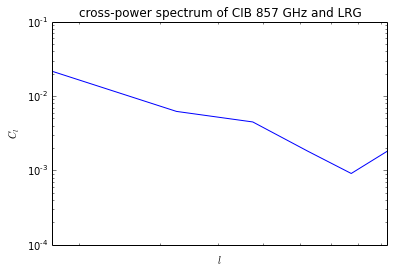

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from corr_utility import *


lmin = 0
binSize = 128
####################################
###         LRG vs. 857          ###
####################################
fn = 'cl_CMASS_857.out'
ell, cl = cl_read(fn)
ell_bin, cl_bin = cl_binned(ell[lmin:], cl[lmin:], binSize)

plt.plot(ell_bin, cl_bin, 'b')
plt.xscale('log')
plt.yscale('log')
plt.xlim([min(ell_bin), max(ell_bin)])
plt.title('cross-power spectrum of CIB 857 GHz and LRG')
plt.ylabel('$C_l$')
plt.xlabel('$l$')
plt.show()

#######################################
###    LRG vs. 857  rotate pi/2     ###
#######################################
# fn = 'cl_lrg_857_rot90.out'
# ell, cl = cl_read(fn)
# ell_bin, cl_bin = cl_binned(ell[lmin:], cl[lmin:], binSize)

# plt.plot(ell_bin, cl_bin, 'b')
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim([min(ell_bin), max(ell_bin)])
# plt.title('Rotated')
# plt.ylabel('$C_l$')
# plt.xlabel('$l$')
# plt.show()